# Prueba A/A/B en una app de productos alimenticios

## Inicialización

Se cargan las librerías.

In [5]:
import pandas as pd
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import numpy as np
from scipy import stats as st
import math as mth

Se cargan los datos.

In [6]:
df = pd.read_csv('logs_exp_us.csv')

## Preparación de datos

Se hace el preprocesamiento de datos y un análisis exploratorio para facilitar una comprensión inicial de los datos.

In [7]:
print(df.head(10))
print()
df.info()

      EventName\tDeviceIDHash\tEventTimestamp\tExpId
0  MainScreenAppear\t4575588528974610257\t1564029...
1  MainScreenAppear\t7416695313311560658\t1564053...
2  PaymentScreenSuccessful\t3518123091307005509\t...
3  CartScreenAppear\t3518123091307005509\t1564054...
4  PaymentScreenSuccessful\t6217807653094995999\t...
5  CartScreenAppear\t6217807653094995999\t1564055...
6  OffersScreenAppear\t8351860793733343758\t15640...
7  MainScreenAppear\t5682100281902512875\t1564085...
8  MainScreenAppear\t1850981295691852772\t1564086...
9  MainScreenAppear\t5407636962369102641\t1564112...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 1 columns):
 #   Column                                       Non-Null Count   Dtype 
---  ------                                       --------------   ----- 
 0   EventName	DeviceIDHash	EventTimestamp	ExpId  244126 non-null  object
dtypes: object(1)
memory usage: 1.9+ MB


Se observa que el dataframe tiene '\t' como separadores, por lo cual se hace la corrección.

In [8]:
df = pd.read_csv('logs_exp_us.csv', sep='\t')
print(df.head(10))
print()
df.info()

                 EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248
5         CartScreenAppear  6217807653094995999      1564055323    248
6       OffersScreenAppear  8351860793733343758      1564066242    246
7         MainScreenAppear  5682100281902512875      1564085677    246
8         MainScreenAppear  1850981295691852772      1564086702    247
9         MainScreenAppear  5407636962369102641      1564112112    246

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName    

### Renombrar columnas

Se renombran las columnas del dataframe pasándolas a formato snake case.

In [9]:
# Se renombran las columnas con un bucle for y se corrobora el cambio

df.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']
print(df.columns)

Index(['event_name', 'device_id_hash', 'event_timestamp', 'exp_id'], dtype='object')


### Corrección de datos

#### Conversión de datos

Se corrige el tipo de datos en las columnas

In [10]:
# Se corrige el tipo de datos en la columna 'date' del dataframe 'orders' a datetime

df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='s')
print(df.head())
print()
df.info()

                event_name       device_id_hash     event_timestamp  exp_id
0         MainScreenAppear  4575588528974610257 2019-07-25 04:43:36     246
1         MainScreenAppear  7416695313311560658 2019-07-25 11:11:42     246
2  PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47     248
3         CartScreenAppear  3518123091307005509 2019-07-25 11:28:47     248
4  PaymentScreenSuccessful  6217807653094995999 2019-07-25 11:48:42     248

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   device_id_hash   244126 non-null  int64         
 2   event_timestamp  244126 non-null  datetime64[ns]
 3   exp_id           244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


### Manejo de datos ausentes y duplicados

No se encuentran datos ausentes en los dataframes, por lo que nos iremos directo con el manejo de datos duplicados.

#### Manejo de duplicados

Se revisa si existen datos duplicados en el dataframe.

In [11]:
# Se revisa el dataframe

print('Líneas duplicadas en el dataframe =', df.duplicated().sum())

Líneas duplicadas en el dataframe = 413


Se observan 413 líneas duplicadas, se indaga más sobre este hecho.

In [12]:
# Se visualizan las líneas duplicadas

print(df[df.duplicated()])

                     event_name       device_id_hash     event_timestamp  \
453            MainScreenAppear  5613408041324010552 2019-07-30 08:19:44   
2350           CartScreenAppear  1694940645335807244 2019-07-31 21:51:39   
3573           MainScreenAppear   434103746454591587 2019-08-01 02:59:37   
4076           MainScreenAppear  3761373764179762633 2019-08-01 03:47:46   
4803           MainScreenAppear  2835328739789306622 2019-08-01 04:44:01   
...                         ...                  ...                 ...   
242329         MainScreenAppear  8870358373313968633 2019-08-07 19:26:44   
242332  PaymentScreenSuccessful  4718002964983105693 2019-08-07 19:26:45   
242360  PaymentScreenSuccessful  2382591782303281935 2019-08-07 19:27:29   
242362         CartScreenAppear  2382591782303281935 2019-08-07 19:27:29   
242635         MainScreenAppear  4097782667445790512 2019-08-07 19:36:58   

        exp_id  
453        248  
2350       248  
3573       248  
4076       247  
48

In [13]:
# Se toma el primer 'device_id_hash' y se visualizan sus datos

print(df[df['device_id_hash'] == 5613408041324010552].sort_values('event_timestamp'))

              event_name       device_id_hash     event_timestamp  exp_id
452     MainScreenAppear  5613408041324010552 2019-07-30 08:19:44     248
453     MainScreenAppear  5613408041324010552 2019-07-30 08:19:44     248
104383  MainScreenAppear  5613408041324010552 2019-08-03 18:41:30     248
104628  MainScreenAppear  5613408041324010552 2019-08-03 18:51:19     248
104637  MainScreenAppear  5613408041324010552 2019-08-03 18:51:37     248
145276  MainScreenAppear  5613408041324010552 2019-08-05 06:33:51     248
145550  MainScreenAppear  5613408041324010552 2019-08-05 06:42:12     248
205860  MainScreenAppear  5613408041324010552 2019-08-06 17:25:35     248
205869  MainScreenAppear  5613408041324010552 2019-08-06 17:25:51     248
205915  MainScreenAppear  5613408041324010552 2019-08-06 17:26:40     248


In [14]:
# El 'device_id_hash' usado no tiene mucha información, se usa el siguiente

print(df[df['device_id_hash'] == 1694940645335807244].sort_values('event_timestamp'))

                     event_name       device_id_hash     event_timestamp  \
2345           MainScreenAppear  1694940645335807244 2019-07-31 21:51:32   
2346           CartScreenAppear  1694940645335807244 2019-07-31 21:51:37   
2348           CartScreenAppear  1694940645335807244 2019-07-31 21:51:39   
2349    PaymentScreenSuccessful  1694940645335807244 2019-07-31 21:51:39   
2350           CartScreenAppear  1694940645335807244 2019-07-31 21:51:39   
2351         OffersScreenAppear  1694940645335807244 2019-07-31 21:51:52   
2353         OffersScreenAppear  1694940645335807244 2019-07-31 21:52:13   
2370           CartScreenAppear  1694940645335807244 2019-07-31 21:54:52   
2371    PaymentScreenSuccessful  1694940645335807244 2019-07-31 21:54:52   
2996           MainScreenAppear  1694940645335807244 2019-08-01 00:56:10   
3003           MainScreenAppear  1694940645335807244 2019-08-01 00:56:21   
3004           MainScreenAppear  1694940645335807244 2019-08-01 00:56:32   
3063        

Nos podemos dar cuenta que, para un mismo usuario, hay eventos diferentes que ocurren en el mismo segundo, pero no significa que sea un error ya que pueden darse inmediatamente uno después del otro. Lo que sí no es común es que el mismo evento se dé en el mismo segundo, pareciera que el registro se duplicara o que el usuario haya hecho la acción dos veces con algún doble clic; incluso hay registro de 3 acciones en el mismo segundo, siendo la primera y la tercera acción la misma, un comportamiento extraño y más por el poco tiempo en el que se hace.  
Por todo lo anterior, se determina que el mejor curso de acción es eliminar las líneas completamente duplicadas.

In [15]:
# Se eliminan las líneas duplicadas

df.drop_duplicates(inplace=True)
print(df.head())
print()
df.info()

                event_name       device_id_hash     event_timestamp  exp_id
0         MainScreenAppear  4575588528974610257 2019-07-25 04:43:36     246
1         MainScreenAppear  7416695313311560658 2019-07-25 11:11:42     246
2  PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47     248
3         CartScreenAppear  3518123091307005509 2019-07-25 11:28:47     248
4  PaymentScreenSuccessful  6217807653094995999 2019-07-25 11:48:42     248

<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 9.3+ MB


Para este tipo de pruebas cada usuario dedbe estar solamente en un grupo experimental, si estuviera en más de un grupo se vería afectada la prueba.

In [16]:
# Se revisa si hay usuarios repetidos en diferentes grupos

print('Lista del número de grupos en los que se puede encontrar cada usuario:', df.groupby('device_id_hash')['exp_id'].nunique().unique())

Lista del número de grupos en los que se puede encontrar cada usuario: [1]


Se observa que cada usuario se encuentra solamente en un grupo experimental, por lo que podemos seguir con el enriquecimiento de datos.

### Enriquecimiento de datos

Se agregan columnas de fecha y de hora.

In [17]:
# Se crean las columnas

df['date'] = df['event_timestamp'].dt.date
df['hour'] = df['event_timestamp'].dt.time
print(df.head())
print()
df.info()

                event_name       device_id_hash     event_timestamp  exp_id  \
0         MainScreenAppear  4575588528974610257 2019-07-25 04:43:36     246   
1         MainScreenAppear  7416695313311560658 2019-07-25 11:11:42     246   
2  PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47     248   
3         CartScreenAppear  3518123091307005509 2019-07-25 11:28:47     248   
4  PaymentScreenSuccessful  6217807653094995999 2019-07-25 11:48:42     248   

         date      hour  
0  2019-07-25  04:43:36  
1  2019-07-25  11:11:42  
2  2019-07-25  11:28:47  
3  2019-07-25  11:28:47  
4  2019-07-25  11:48:42  

<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime

## Análisis de datos inicial

### Estudio y comprobación de datos

Se calcula el número de eventos que hay en los registros así como el total de usuarios y el promedio de eventos por usuario.

In [18]:
# Se muestran los datos

print('Total de eventos =', df['event_name'].count())
print()
print('Total de usuarios =', df['device_id_hash'].nunique())
print()
print('Promedio de eventos por usuario =', df.groupby('device_id_hash')['event_name'].count().mean().round(1))

Total de eventos = 243713

Total de usuarios = 7551

Promedio de eventos por usuario = 32.3


Se visualiza el periodo de tiempo que cubren los datos y cuándo empieza a hacerse el registro completo.

date
2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
2019-07-30      412
2019-07-31     2030
2019-08-01    36141
2019-08-02    35554
2019-08-03    33282
2019-08-04    32968
2019-08-05    36058
2019-08-06    35788
2019-08-07    31096
Name: event_name, dtype: int64


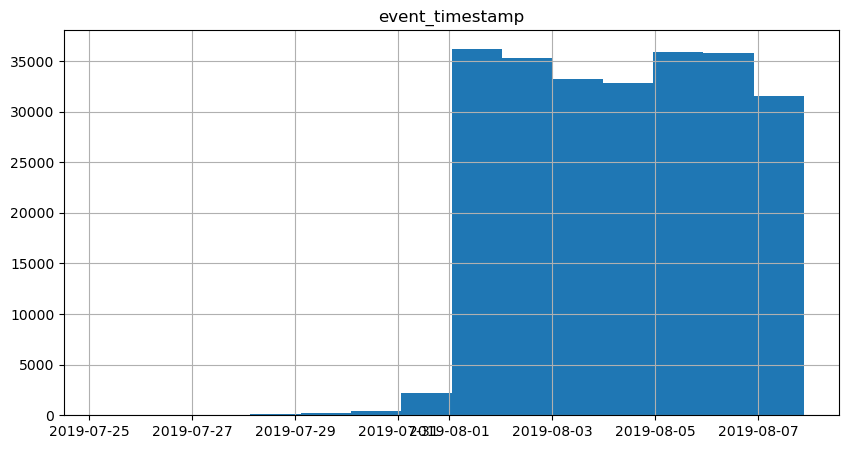

In [19]:
# Se calculan los eventos por día y se grafica un histograma

print(df.groupby('date')['event_name'].count())

df.hist('event_timestamp', figsize=(10,5), bins=14)
plt.show()

Se observa que los datos comprenden del 25 de julio al 7 de agosto del 2019, aunque lo datos completos se empiezan a registrar desde el 1° de agosto, por lo que se procede a eliminar los eventos antes de este día.

In [20]:
# Se eliminan los eventos antes del 1° de agosto

df_filtered = df[df['event_timestamp'] >= '2019-08-01']
print(df_filtered.head())
print()
df_filtered.info()

              event_name       device_id_hash     event_timestamp  exp_id  \
2828            Tutorial  3737462046622621720 2019-08-01 00:07:28     246   
2829    MainScreenAppear  3737462046622621720 2019-08-01 00:08:00     246   
2830    MainScreenAppear  3737462046622621720 2019-08-01 00:08:55     246   
2831  OffersScreenAppear  3737462046622621720 2019-08-01 00:08:58     246   
2832    MainScreenAppear  1433840883824088890 2019-08-01 00:08:59     247   

            date      hour  
2828  2019-08-01  00:07:28  
2829  2019-08-01  00:08:00  
2830  2019-08-01  00:08:55  
2831  2019-08-01  00:08:58  
2832  2019-08-01  00:08:59  

<class 'pandas.core.frame.DataFrame'>
Index: 240887 entries, 2828 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       240887 non-null  object        
 1   device_id_hash   240887 non-null  int64         
 2   event_timestamp  240887 non-null 

Al exlcluir los datos más antiguos se perdieron datos, se calculan a continuación.

In [21]:
# Se muestran los datos actuales

print('Total de eventos =', df_filtered['event_name'].count(),
      '(', round(100 * df_filtered['event_name'].count() / df['event_name'].count(), 2), '% )')
print('Se perdieron', df['event_name'].count() - df_filtered['event_name'].count(), 'eventos')
print()
print('Total de usuarios =', df_filtered['device_id_hash'].nunique(),
      '(', round(100 * df_filtered['device_id_hash'].nunique() / df['device_id_hash'].nunique(),2), '% )')
print('Se perdieron', df['device_id_hash'].nunique() - df_filtered['device_id_hash'].nunique(), 'usuarios')

Total de eventos = 240887 ( 98.84 % )
Se perdieron 2826 eventos

Total de usuarios = 7534 ( 99.77 % )
Se perdieron 17 usuarios


Ahora nos aseguramos de que haya usuarios en los 3 grupos experimentales.

In [22]:
# Se muestra el número de usuarios por grupo

print(df_filtered.groupby('exp_id')['device_id_hash'].nunique())

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64


Efectivamente se tiene un número parecido de usuarios en cada uno de los grupos experimentales, por lo que podemos seguir con nuestro análisis.

### Estudio de embudo de eventos

Se indaga la frecuencia de cada evento registrado en el dataframe.

In [23]:
# Se muestra qué eventos están registrados y cuantos usuarios realizaron cada acción

print(df_filtered.groupby('event_name')['device_id_hash'].count().sort_values(ascending=False))

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: device_id_hash, dtype: int64


Se procede a averiguar la cantidad de usuarios que realizaron cada una de estas acciones y la proporción de usuarios que realizaron la acción al menos una vez.

In [24]:
# Se calcula el número de usarios únicos que hicieron cada acción

eventos = df_filtered.groupby('event_name', as_index=False)['device_id_hash'].nunique().sort_values('device_id_hash', ascending=False).reset_index(drop=True)
eventos.columns = ['event_name', 'cantidad']
print(eventos)

                event_name  cantidad
0         MainScreenAppear      7419
1       OffersScreenAppear      4593
2         CartScreenAppear      3734
3  PaymentScreenSuccessful      3539
4                 Tutorial       840


In [25]:
# Se calcula la proporción de usuarios que realizaron la acción al menos una vez

eventos['conversion_total'] = (eventos['cantidad'] / df['device_id_hash'].nunique())
print(eventos)

                event_name  cantidad  conversion_total
0         MainScreenAppear      7419          0.982519
1       OffersScreenAppear      4593          0.608264
2         CartScreenAppear      3734          0.494504
3  PaymentScreenSuccessful      3539          0.468680
4                 Tutorial       840          0.111244


Se observa que el número de eventos es congruente con el proceso de hacer una compra. Se observa que para el proceso de hacer una compra, el usuario tiene que hacer forzosamente los siguientes pasos en el siguiente orden:

1. MainScreenAppear: primero se tiene que abrir la app, y al hacerlo aparece la pantalla principal de la misma.
2. CartScreenAppear: después de agregar los productos a su carrito, se tiene que ir a ver el contenido en la pantalla del carrito para editar y verificar que estén los productos deseados.
3. PaymentScreenSuccessful: por último se tiene que pagar por todo el conetenido del carrito, en donde aparece la pantalla de pago exitoso.

Los siguientes eventos no son necesarios para el proceso de la compra:

1. OffersScreenAppear: Aunque es evidente que la pantalla de ofertas de la app atrae más compras de los usuarios, esta no es indispensable en el proceso de compra (esta pantalla no tiene que aparecer si el usuario necesita comprar).
2. Tutorial: Esta pantalla aparece cuando el usuario necesita ayuda sobre el manejo de la app, pero es opcional y para nada necesaria para el proceso de la compra.

Ahora que se tiene clara la secuencia de eventos, se encontrará la proporción de usuarios que pasan de una etapa a la siguiente.

In [26]:
# Se calcula la proporción de usuarios que pasan de una etapa a la siguiente

secuencia = ['MainScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
embudo = eventos[eventos['event_name'].isin(secuencia)].copy()
embudo['conversion_siguiente_etapa'] = embudo['cantidad'].pct_change() + 1
embudo = embudo.fillna(1)
print(embudo)

                event_name  cantidad  conversion_total  \
0         MainScreenAppear      7419          0.982519   
2         CartScreenAppear      3734          0.494504   
3  PaymentScreenSuccessful      3539          0.468680   

   conversion_siguiente_etapa  
0                    1.000000  
2                    0.503302  
3                    0.947777  


In [27]:
# Se grafica el embudo

fig = go.Figure(go.Funnel(y = embudo['event_name'], x = embudo['cantidad'], textinfo = "value+percent initial"))
fig.show()

Se hará lo mismo pero incluyendo OffersScreenAppear para ver como afecta al proceso completo.

In [28]:
# Se calcula la proporción de usuarios que pasan de una etapa a la siguiente incluyendo OffersScreenAppear

secuencia_ofertas= ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
embudo_ofertas= eventos[eventos['event_name'].isin(secuencia_ofertas)].copy()
embudo_ofertas['conversion_siguiente_etapa'] = embudo_ofertas['cantidad'].pct_change() + 1
embudo_ofertas = embudo_ofertas.fillna(1)
print(embudo_ofertas)

                event_name  cantidad  conversion_total  \
0         MainScreenAppear      7419          0.982519   
1       OffersScreenAppear      4593          0.608264   
2         CartScreenAppear      3734          0.494504   
3  PaymentScreenSuccessful      3539          0.468680   

   conversion_siguiente_etapa  
0                    1.000000  
1                    0.619086  
2                    0.812976  
3                    0.947777  


In [29]:
# Se grafica el embudo

fig = go.Figure(go.Funnel(y = embudo_ofertas['event_name'], x = embudo_ofertas['cantidad'], textinfo = "value+percent initial"))
fig.show()

Se puede observar que se pierde la mayoría de usuarios en la transición del primer al segundo evento (en ambos embudos). Aun así hay muchos usuarios pasan por todos los eventos llegando al último (el pago), un 47.7% de los usuarios que inician el proceso para ser exactos.

## Estudio de los resultados

Se vuelve a observar el número de usuarios que hay en cada grupo experimental.

In [30]:
# Se muestra el número de usuarios por grupo

print(df_filtered.groupby('exp_id')['device_id_hash'].nunique())

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64


En las pruebas A/B (más específicamente la prueba A/A/B) que se harán a continuación se realizarán para comprobar si la diferencia entre los grupos es estadísticamente significativa en cuanto a la proporción de usuarios que realizaron cada una de las acciones.

Se crea una función para realizar todas las pruebas del estadístico Z (A1/A2, A1/B y A2/B) e imprimir todos los resultados.

In [31]:
# Se crea la función para las pruebas A/B

def test(dfA, dfB, alfa):
    
    events = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
    results = []
    
    for event in events:
        
        dfA_event = dfA[dfA['event_name'] == event]
        dfB_event = dfB[dfB['event_name'] == event]
        
        dfA_event = dfA_event.groupby('device_id_hash')['event_name'].nunique()
        dfB_event = dfB_event.groupby('device_id_hash')['event_name'].nunique()
        
        users_dfA = dfA['device_id_hash'].nunique()
        users_dfB = dfB['device_id_hash'].nunique()

        users_event_dfA = len(dfA_event)
        users_event_dfB = len(dfB_event)

        p1 = users_event_dfA / users_dfA
        p2 = users_event_dfB / users_dfB
        p_combined = (users_event_dfA + users_event_dfB) / (users_dfA + users_dfB)

        z = (p1 - p2) / mth.sqrt(p_combined * (1 - p_combined) * ((1 / users_dfA) + (1 / users_dfB)))
        distr = st.norm(0, 1)
        p_value = (1 - distr.cdf(abs(z))) * 2

        print('Prueba para el evento --', event, '--')
        print()
        print('Proporción de usuarios que realizaron esta acción:')
        print('Grupo 1 =', round(p1, 5), '(', round(p1 * 100, 2), '% )')
        print('Grupo 2 =', round(p2, 5), '(', round(p2 * 100, 2), '% )')
        print()
        print('Valor p =', p_value.round(5), '(', (p_value * 100).round(2), '% )')
        print()
        if p_value < alfa:
            print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
        else:
            print("No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes")
        print()
        print()
        
    #return results

### Prueba A1/A2

En esta prueba compararemos los dos grupos de control para comprobar nuestros mecanismos y cálculos. En este caso se compararán los grupos de control 246 y 247.

El valor p del estadístico Z se comparará con un valor alfa de 0.05 (5%)

In [32]:
# Se saca la información de los grupos 246 (A1) y 247 (A2)

A1 = df_filtered[df_filtered['exp_id'] == 246]
A2 = df_filtered[df_filtered['exp_id'] == 247]

# Se realiza la prueba

prueba_A1A2 = test(A1, A2, .05)

Prueba para el evento -- MainScreenAppear --

Proporción de usuarios que realizaron esta acción:
Grupo 1 = 0.98631 ( 98.63 % )
Grupo 2 = 0.98528 ( 98.53 % )

Valor p = 0.75706 ( 75.71 % )

No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


Prueba para el evento -- OffersScreenAppear --

Proporción de usuarios que realizaron esta acción:
Grupo 1 = 0.62077 ( 62.08 % )
Grupo 2 = 0.60485 ( 60.49 % )

Valor p = 0.2481 ( 24.81 % )

No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


Prueba para el evento -- CartScreenAppear --

Proporción de usuarios que realizaron esta acción:
Grupo 1 = 0.50966 ( 50.97 % )
Grupo 2 = 0.49264 ( 49.26 % )

Valor p = 0.22883 ( 22.88 % )

No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


Prueba para el evento -- PaymentScreenSuccessful --

Proporción de usuarios que realizaron esta acción:
Grupo 1 = 0.48309 ( 48

Al no poder rechazar ninguna de las hipótesis en cada uno de los eventos comparados, se determina que los grupos se dividieron correctamente y que la diferencia entre los grupos no es estadísticamente significativa.

### Prueba A1/B

En esta prueba compararemos el grupo de control 246 con el grupo con fuentes alteradas 248.

El valor p del estadístico Z se comparará con un valor alfa de 0.05 (5%)

In [33]:
# Se saca la información del grupo 248 (B)

B = df_filtered[df_filtered['exp_id'] == 248]

# Se realiza la prueba

prueba_A1B = test(A1, B, .05)

Prueba para el evento -- MainScreenAppear --

Proporción de usuarios que realizaron esta acción:
Grupo 1 = 0.98631 ( 98.63 % )
Grupo 2 = 0.98266 ( 98.27 % )

Valor p = 0.29497 ( 29.5 % )

No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


Prueba para el evento -- OffersScreenAppear --

Proporción de usuarios que realizaron esta acción:
Grupo 1 = 0.62077 ( 62.08 % )
Grupo 2 = 0.60347 ( 60.35 % )

Valor p = 0.20836 ( 20.84 % )

No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


Prueba para el evento -- CartScreenAppear --

Proporción de usuarios que realizaron esta acción:
Grupo 1 = 0.50966 ( 50.97 % )
Grupo 2 = 0.48482 ( 48.48 % )

Valor p = 0.07843 ( 7.84 % )

No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


Prueba para el evento -- PaymentScreenSuccessful --

Proporción de usuarios que realizaron esta acción:
Grupo 1 = 0.48309 ( 48.

A pesar de que los valores de p se acercaban un poco más al valor del nivel de significancia (alfa), al no poder rechazar ninguna de las hipótesis en cada uno de los eventos comparados, se determina que la diferencia entre los grupos no es estadísticamente significativa.

### Prueba A2/B

En esta prueba compararemos el grupo de control 247 con el grupo con fuentes alteradas 248.

El valor p del estadístico Z se comparará con un valor alfa de 0.05 (5%)

In [34]:
# Se realiza la prueba

prueba_A2B = test(A2, B, .05)

Prueba para el evento -- MainScreenAppear --

Proporción de usuarios que realizaron esta acción:
Grupo 1 = 0.98528 ( 98.53 % )
Grupo 2 = 0.98266 ( 98.27 % )

Valor p = 0.45871 ( 45.87 % )

No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


Prueba para el evento -- OffersScreenAppear --

Proporción de usuarios que realizaron esta acción:
Grupo 1 = 0.60485 ( 60.49 % )
Grupo 2 = 0.60347 ( 60.35 % )

Valor p = 0.91978 ( 91.98 % )

No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


Prueba para el evento -- CartScreenAppear --

Proporción de usuarios que realizaron esta acción:
Grupo 1 = 0.49264 ( 49.26 % )
Grupo 2 = 0.48482 ( 48.48 % )

Valor p = 0.57862 ( 57.86 % )

No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


Prueba para el evento -- PaymentScreenSuccessful --

Proporción de usuarios que realizaron esta acción:
Grupo 1 = 0.4608 ( 46

En esta comparación los valores de p se alejaban mucho del nivel de significancia (alfa), al no poder rechazar ninguna de las hipótesis en cada uno de los eventos comparados, se determina que la diferencia entre los grupos no es estadísticamente significativa.

## Conclusión general

Sabemos que al hacer varias comparaciones con los mismos datos (pruebas múltiples) la probabilidad de cometer un error tipo I aumenta con cada nueva prueba de hipótesis (la probabilidad de que la prueba produzca un resultado falso positivo). Esto nos obliga a ajustar el nivel de significancia global de un conjunto de pruebas cuando llevamos a cabo comparaciones múltiples.

Pero como en todas las pruebas no se pudo rechazar ninguna hipótesis nula, no es necesario ajustar el nivel de significancia, ya que al hacerlo se disminuye el valor de alfa alejándose aún más de los valores p de cada prueba, ratificando aún más la posible nula diferencia entre las proporciones de los grupos experimentales.

Por lo tanto se concluye que los cambios de las fuentes de toda la aplicación realizados por el equipo de diseño no tuvieron ningún impacto en el comportamiento de los usuarios.